In [1]:
import os.path
import sys
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
import scoping
from scoping.models import *
from utils.text import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

import pandas as pd
import numpy as np

import pickle
import scipy.sparse

import matplotlib.pyplot as plt

In [2]:
seen_df = pd.read_csv('../data/0_labelled_documents.csv')

df = (seen_df
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index
r_index = df[df["random_sample"]==1].index
physical_index = df[df['physical_tags']==1].index

In [3]:
from alterations import postfix_data

df = postfix_data(df)

In [4]:
catids = [710,320,321,323,322,324]
cats = [Category.objects.get(pk=cid) for cid in catids]
all_classes = []
i = 0
broad_cats = []
for c in cats:
    bc = {"start":i,"name": c.name}
    for ec in c.equivalents.filter(level=4).exclude(name__icontains="<hidden>").order_by('name','level'):
        ecname = f"{ec.level} - {ec.name}"
        if ecname in df.columns and df[ecname].sum()>=5:
            all_classes.append(ecname)
            i+=1
    bc["end"] = i
    bc["size"] = i-bc["start"]
    broad_cats.append(bc)
            
print(len(all_classes))
broad_cats

48


[{'end': 9, 'name': 'Physical systems', 'size': 9, 'start': 0},
 {'end': 13, 'name': 'Mountains, snow and ice', 'size': 4, 'start': 9},
 {'end': 20,
  'name': 'Rivers, lakes, and soil moisture',
  'size': 7,
  'start': 13},
 {'end': 27, 'name': 'Coastal and marine Ecosystems', 'size': 7, 'start': 20},
 {'end': 36, 'name': 'Terrestrial ES', 'size': 9, 'start': 27},
 {'end': 48, 'name': 'Human and managed', 'size': 12, 'start': 36}]

12 - Physical systems
139
Physical systems
[{'name': '11 Storms'}, {'name': '11 Storms'}, {'name': '08 Changes in strong precipitation'}, {'name': '14 Sea level change'}, {'name': '15 Coastal flooding'}, {'name': '05 Changes in precipitation'}, {'name': '05 Changes in precipitation'}, {'name': '16 Sea surface temperature'}, {'name': '18 Oxygen content'}, {'name': '19 Water quality/chemistry (oceans)'}, {'name': '07 Aridity/dryness'}, {'name': '19 Water quality/chemistry (oceans)'}, {'name': '08 Changes in strong precipitation'}, {'name': '07 Aridity/dryness'}, {'name': '14 Sea level change'}, {'name': '17 Ocean acidification'}, {'name': '18 Oxygen content'}, {'name': '02 Air or land surface temperature changes'}, {'name': '17 Ocean acidification'}, {'name': '04 Radiation'}, {'name': '12 Seasonality'}, {'name': '06 Humidity'}, {'name': '01 CO2 concentration'}, {'name': '04 Radiation'}, {'name': '06 Humidity'}, {'name': '10 Wind speed'}, {'name': '12 Seasonality'}, {'name': '13 Other (ph

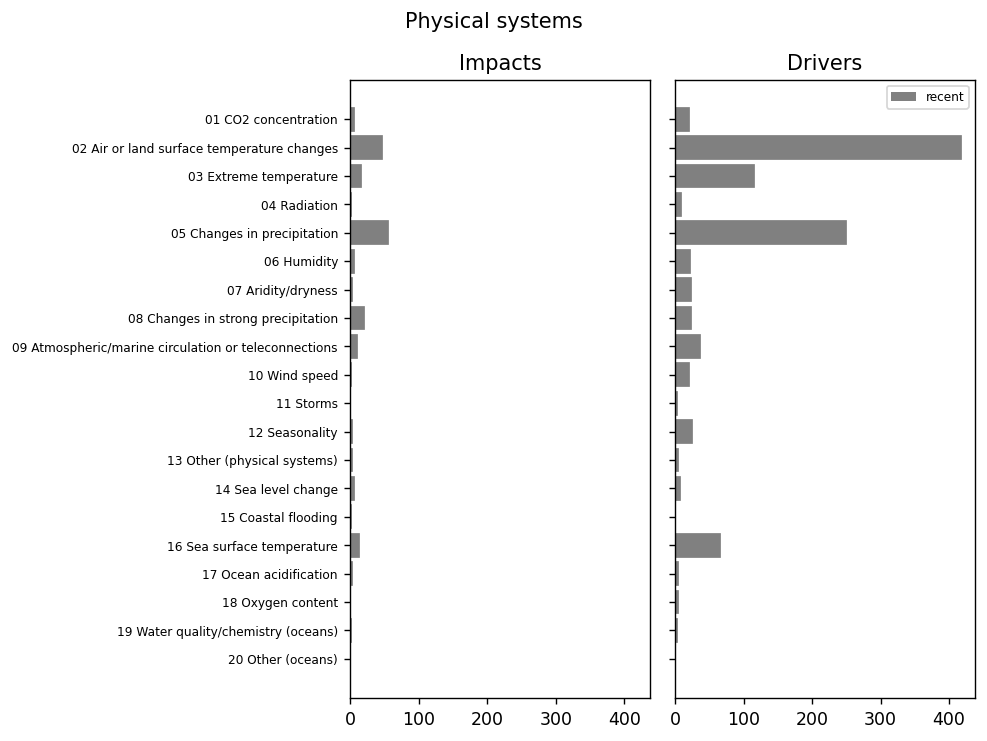

12 - Mountains, snow and ice
135.0
Mountains, snow and ice
[{'name': '34 Glacier retreat'}, {'name': '33 Sea ice retreat'}, {'name': '30 Snow'}, {'name': '30 Snow'}, {'name': '35 Other (mountains, snow and ice)'}, {'name': '31 Landslides/instability'}, {'name': '35 Other (mountains, snow and ice)'}, {'name': '31 Landslides/instability'}, {'name': '32 Permafrost'}, {'name': '32 Permafrost'}, {'name': '33 Sea ice retreat'}, {'name': '34 Glacier retreat'}]
135.0


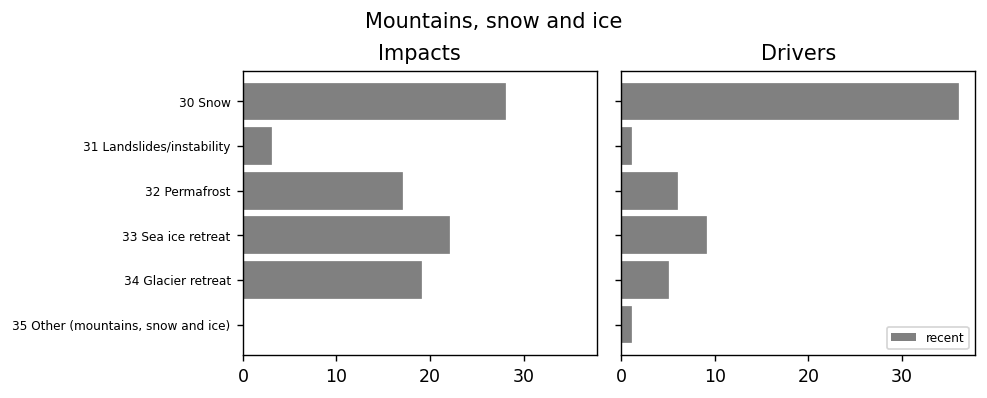

12 - Rivers, lakes, and soil moisture
268.0
Rivers, lakes, and soil moisture
[{'name': '28 River runoff'}, {'name': '23 Soil moisture'}, {'name': '23 Soil moisture'}, {'name': '24 Water level (lake, reservoir, groundwater)'}, {'name': '25 Evapotranspiration'}, {'name': '25 Evapotranspiration'}, {'name': '27 River floods'}, {'name': '27 River floods'}, {'name': '28 River runoff'}, {'name': '29 Other (Rivers, lakes and soil moisture)'}, {'name': '29 Other (Rivers, lakes and soil moisture)'}, {'name': '24 Water level (lake, reservoir, groundwater)'}, {'name': '26 Drought frequency and intensity'}, {'name': '26 Drought frequency and intensity'}, {'name': '22 Water quality/chemistry (freshwater)'}, {'name': '22 Water quality/chemistry (freshwater)'}, {'name': '21 Water temperature (freshwater)'}, {'name': '21 Water temperature (freshwater)'}]
268.0


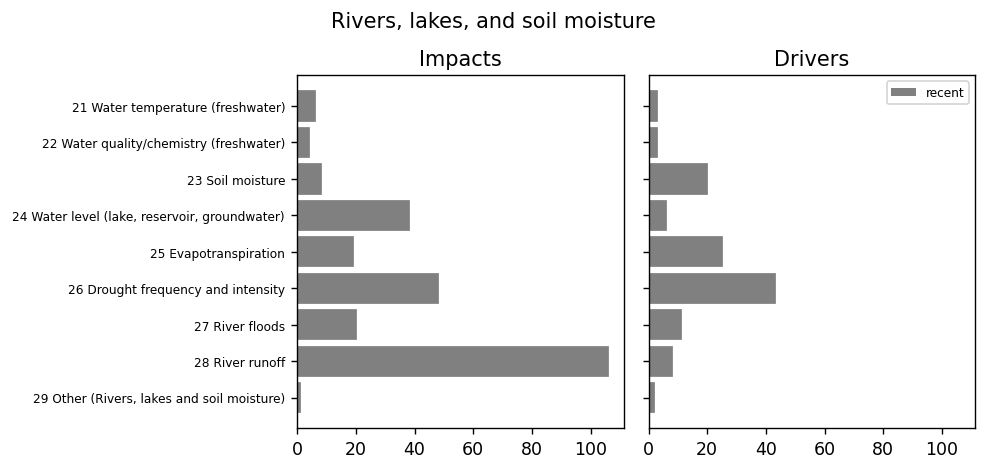

12 - Coastal and marine Ecosystems
136.0
Coastal and marine Ecosystems
[{'name': '40 Changes in warm water corals'}, {'name': '48 Carbon cycle (marine & coastal)'}, {'name': '46 Changes in kelp forests'}, {'name': '44 Biodiversity effects (marine & coastal)'}, {'name': '37 Shifts in phenology (marine & coastal)'}, {'name': '42 Species abundance (marine & coastal)'}, {'name': '45 Ocean ecosystem productivity'}, {'name': '47 Seagrass'}, {'name': '43 Biome shift (marine & coastal)'}, {'name': '37 Shifts in phenology (marine & coastal)'}, {'name': '38 Geographical shift  (marine & coastal)'}, {'name': '40 Changes in warm water corals'}, {'name': '44 Biodiversity effects (marine & coastal)'}, {'name': '45 Ocean ecosystem productivity'}, {'name': '36 Species distribution (marine & coastal)'}, {'name': '46 Changes in kelp forests'}, {'name': '47 Seagrass'}, {'name': '48 Carbon cycle (marine & coastal)'}, {'name': '49 Biogeochemical flows (marine & coastal)'}, {'name': '42 Species abundance (m

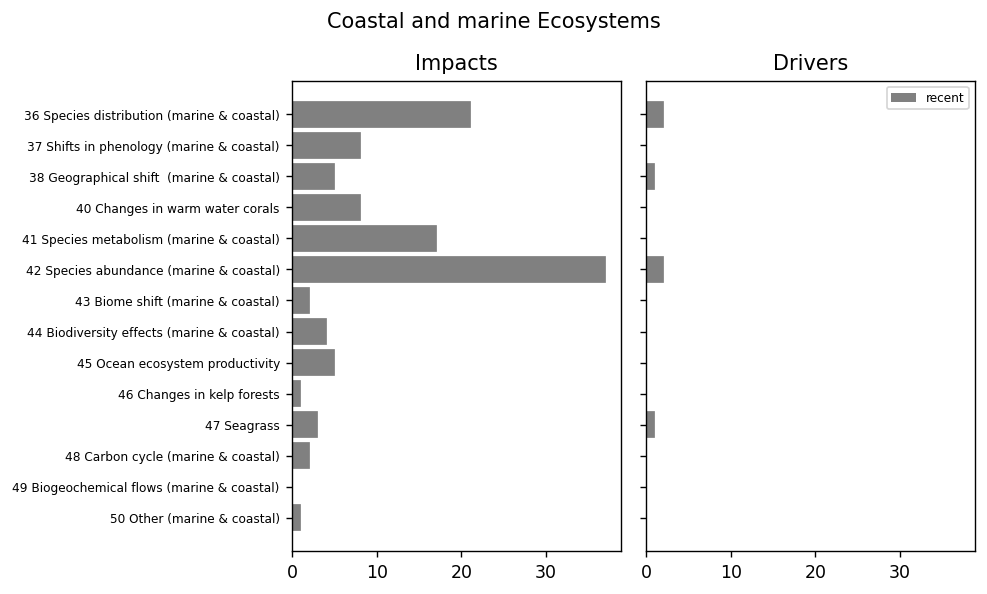

12 - Terrestrial ES
416.0
Terrestrial ES
[{'name': '59 Wildfires'}, {'name': '58 Geographical shift  (Terrestrial and freshwater)<hidden>'}, {'name': '58 Carbon flux (Terrestrial and freshwater)<hidden>'}, {'name': '52 Species abundance (Terrestrial and freshwater)<hidden>'}, {'name': '58 Biodiversity effects (Terrestrial and freshwater)<hidden>'}, {'name': '58 Biome shift (Terrestrial and freshwater)<hidden>'}, {'name': '58 Vegetation<hidden>'}, {'name': '48 Species distribution (Terrestrial and freshwater)<hidden>'}, {'name': '58 Species metabolism (Terrestrial and freshwater)<hidden>'}, {'name': '58 Vegetation<hidden>'}, {'name': '58 Ecosystem productivity (Terrestrial and freshwater)<hidden>'}, {'name': '58 Biodiversity effects (Terrestrial and freshwater)<hidden>'}, {'name': '58 Carbon flux (Terrestrial and freshwater)<hidden>'}, {'name': '59 Wildfires'}, {'name': '58 Geographical shift  (Terrestrial and freshwater)<hidden>'}, {'name': '51 Distribution and range shifts (Terrestria

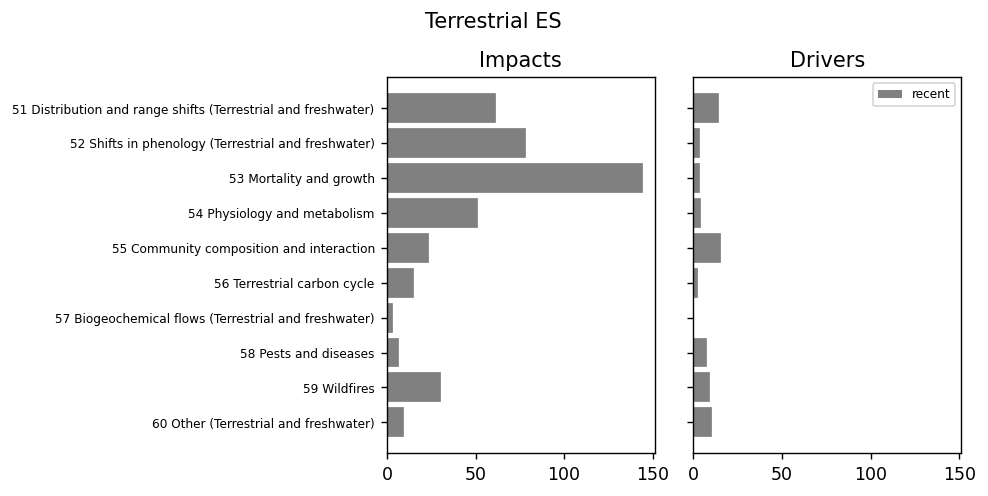

12 - Human and managed
264.0
Human and managed
[{'name': '81 Other (human and managed systems)'}, {'name': '66 Health'}, {'name': '63 Human Settlements'}, {'name': '81 Other (human and managed systems)'}, {'name': '71 Malnutrition'}, {'name': '73 Displacement and migration'}, {'name': '69 Crop yields'}, {'name': '77 Land use change'}, {'name': '65 Gender specific / gender unequal impacts'}, {'name': '68 Extreme heat exposure'}, {'name': '79 Livestock health'}, {'name': '80 Livestock management'}, {'name': '80 Livestock management'}, {'name': '70 Food prices'}, {'name': '75 Economic activity'}, {'name': '74 Economic inequality'}, {'name': '79 Livestock health'}, {'name': '77 Land use change'}, {'name': '62 Coastal human systems'}, {'name': '64 Indigenous communities'}, {'name': '67 Vector-borne diseases'}, {'name': '61 Arctic infrastructure'}, {'name': '39 Changes in fisheries output/catch (potential)'}, {'name': '63 Human Settlements'}, {'name': '61 Arctic infrastructure'}, {'name': '6

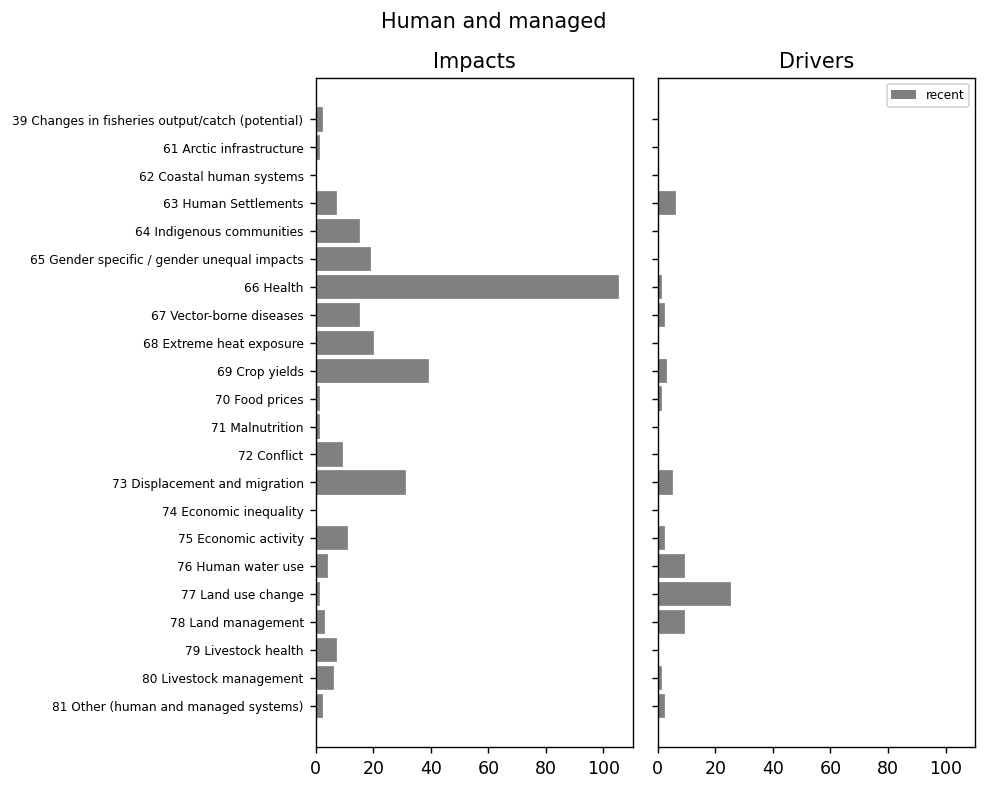

In [5]:

django.db.connection.close()
catids = [710,320,321,323,322,324]
cats = [Category.objects.get(pk=cid) for cid in catids]
p = Project.objects.get(pk=178)
cats
classes = []


recent_tag_ids = list(Tag.objects.filter(query__project=p,id__gt=5361).values_list('doc__id',flat=True))

for c in cats:
    cname = f"{c.level} - {c.name}"
    print(cname)
    if cname in df.columns:
        pass
        print(df[cname].sum())
    else:
        df[cname] = 0
        print(0)
        
    fig, axs = plt.subplots(1,2,dpi=125,figsize=(8,2+0.2*c.equivalents.exclude(name__icontains='<hidden>').count()/2),sharey=True,sharex=True)
    ticks = []
    i = -1
    print(c)
    print(list(c.equivalents.values('name')))
    for ec in c.equivalents.all().order_by('-name','level'):
        ecname = f"{ec.level} - {ec.name}"

        
        if "<hidden>" not in ec.name:
            if ec.level==4:
                i+=1
                ticks.append(ec.name)
        
        if ecname in df.columns:
            if ec.level==4:
                df.loc[df[ecname]==1,cname] = 1  
            if "<hidden>" not in ec.name:
                if ec.level==4:
                    axs[0].barh(i, df.loc[~df['id'].isin(recent_tag_ids),ecname].sum(),color="none",edgecolor="grey",linewidth=1)
                    axs[0].barh(i, df.loc[df['id'].isin(recent_tag_ids),ecname].sum(),left=
                                df.loc[~df['id'].isin(recent_tag_ids),ecname].sum(),color="grey",edgecolor="grey",linewidth=1)
                else:
                    axs[1].barh(i, df.loc[~df['id'].isin(recent_tag_ids),ecname].sum(),color="none",edgecolor="grey",linewidth=1)
                    axs[1].barh(i, df.loc[df['id'].isin(recent_tag_ids),ecname].sum(),left=
                                df.loc[~df['id'].isin(recent_tag_ids),ecname].sum(),color="grey",edgecolor="grey",linewidth=1)
                
    if df[cname].sum()>0:
        if cname != "12 - Physical systems":
            classes.append(cname)
    print(df[cname].sum())
    
    axs[0].set_title("Impacts")
    axs[1].set_title("Drivers")
    
    axs[0].set_yticks(range(len(ticks)))
    axs[0].set_yticklabels(ticks,fontsize=7)
    
    axs[1].barh([0],[0],label="recent",color="grey")
    axs[1].legend(fontsize=7)
    
    plt.suptitle(c.name)
    fig.tight_layout()
    plt.subplots_adjust(top=0.81+0.002*c.equivalents.exclude(name__icontains='<hidden>').count())
    
    plt.savefig(f'../plots/progress/cats_labels_{c.name.replace(" ","_")}.pdf',bbox_inches="tight")
    
    plt.show()

In [6]:
df.to_csv('../data/0_labelled_documents.csv',index=False)
